#### FIND HF

In [6]:
import sys
sys.path.append('../../CppToPython')

In [11]:
import numpy as np
import time
import GeDiM4Py as gedim
import torch
import torch.nn as nn
import numpy as np
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
from torch.optim.lr_scheduler import LambdaLR

In [12]:
lib = gedim.ImportLibrary("../../CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

In [13]:
def set_seed(seed=23):
    random.seed(seed)                        # seed Python random
    np.random.seed(seed)                     # seed numpy random
    torch.manual_seed(seed)                  # seed CPU
    torch.cuda.manual_seed(seed)             # seed GPU (if available)
    torch.cuda.manual_seed_all(seed)         # se hai più GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [14]:
set_seed(23)

In [15]:
# attenzione: ricordati poi di premoltiplicare per il parametro, se c'è
def Diffusion_a(numPoints, points): # vettore unitario che moltiplica il primo integrale
	values_a = np.ones(numPoints, order='F')
	return values_a.ctypes.data
# vettore unitario che moltiplica il secondo integrale
def Reaction_b(numPoints, points): 
	values_b = np.ones(numPoints, order='F')
	return values_b.ctypes.data
# vettore con exp(mu_1*u) valutato nei punti di quadratura(?)
def Reaction_non_linear_b(numPoints, points, u, u_x, u_y): 
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	values_nl_b = np.exp(mu_1*vecu) # nota: abbiamo già elevato alla mu_1 qui
	return values_nl_b.ctypes.data
 # f_1 (è uguale al Lab 12)
def Term_non_linear_der_f_1(numPoints, points, u, u_x, u_y):
	vecu_x = gedim.make_nd_array(u_x, numPoints, np.double)
	vecu_y = gedim.make_nd_array(u_y, numPoints, np.double)
	values_nl_d_f = np.zeros((2, numPoints), order='F')
	values_nl_d_f[0,:] = vecu_x
	values_nl_d_f[1,:] = vecu_y
	return values_nl_d_f.ctypes.data
# f_2
def Term_non_linear_f_2(numPoints, points, u, u_x, u_y): 
    vecu = gedim.make_nd_array(u, numPoints, np.double)
    values_nl_b = np.exp(mu_1*vecu) # nota: abbiamo già elevato alla mu_1 qui
    #print("vecu max:", np.max(vecu))
    #print("mu_1 * vecu max:", np.max(mu_1 * vecu))
    return values_nl_b.ctypes.data

# f_4 (parte con la g)
def Term_f_4(numPoints, points): 
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values_f = 100 * np.sin(2*np.pi*matPoints[0,:]) * np.cos(2*np.pi*matPoints[1,:])
	return values_f.ctypes.data

def Ones_f_2(numPoints, points): # serve per f_2
	values_one = np.ones(numPoints, order='F')
	return values_one.ctypes.data
    
def Ones_f_3(numPoints, points): # serve per f_3
	values_one = np.ones(numPoints, order='F')
	return values_one.ctypes.data
    
def OnesDerivative_f_1(numPoints, points): # serve per f_1
	values_one_d = np.ones((2, numPoints), order='F')
	return values_one_d.ctypes.data
# serve per il calcolo delle norme (tipo ||du|| = ||du-0||
def Zeros(numPoints, points):
	values_zero = np.zeros(numPoints, order='F')
	return values_zero.ctypes.data
# serve per la nroma H1
def ZerosDerivative(direction, numPoints, points):
	values_zero_d = np.zeros(numPoints, order='F')
	return values_zero_d.ctypes.data


In [16]:
meshSize = 0.001
order = 1

In [17]:
domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize }
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)

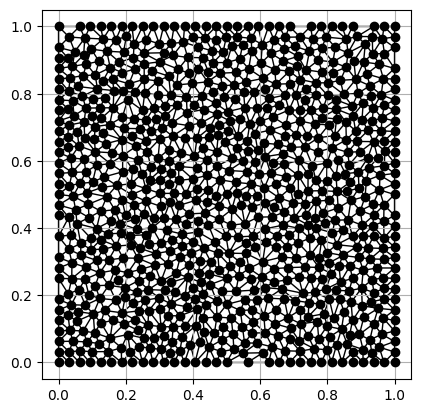

In [18]:
gedim.PlotMesh(mesh)

In [19]:
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] }
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

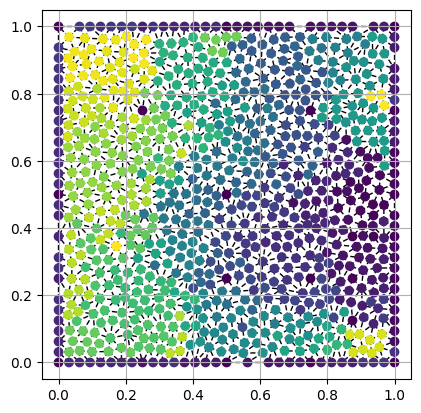

In [20]:
gedim.PlotDofs(mesh, dofs, strongs)

In [21]:
residual_norm = 1.0  # per farlo entare nel loop
solution_norm = 1.0 #per farlo entarre nel loop
newton_tol = 1.0e-8 #tolleranza relativa
max_iterations = 100 # eventualmente, modifica
num_iteration = 1

In [22]:
# initial guess u
u_k = np.zeros(problemData['NumberDOFs'], order='F') # eventualmente modifica: così potrebbe non convergere
# value on the border (=0) bc homogenous dirichlet
u_strong = np.zeros(problemData['NumberStrongs'], order='F')

In [23]:
test_set = np.random.uniform(low=0.1, high=1, size=(100, 2)) # test set

In [24]:
# Troviamo le soluzioni high fidelity 

print("{:<8s} {:<6s} {:>14s} {:>10s} {:>10s} {:>15s}".format(
    "DOFs", "h", "Rel. Residual", "Iter", "Max Iter", "mu = (μ₀, μ₁)"
))
#Possono stare fuori tutti i temini che non dipendono da termini non lienari (uk) e quindi detro il while loro, e quelli che non dipendono da mu
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Diffusion_a, problemData, lib)
forcingTerm_f_4 = gedim.AssembleForcingTerm(Term_f_4, problemData, lib)
forcingTerm_f_3 = gedim.AssembleForcingTerm(Ones_f_3, problemData, lib)

# append the solutions
sol_hf = []
# append the sum of total time taken to solve ONLY the linear systems in the while loop, for each mu is it a sum of the total time taken in all ietrations
times_hf = []
# append solution on quadrature points
sol_quad_hf = []
#append solution derivative wrt x on quadraure points
der_x_quad_hf = []
#append solution derivative wrt y on quadraure points
der_y_quad_hf = []


for mu in test_set:
    # devo riaggiornare u_k inizale ogni volta, (ma in realtà ha anche senso dargli la soluzione precednte che è buona per avere una convergenza più rapida)
    u_k = np.zeros(problemData['NumberDOFs'], order='F')
    mu_0 = mu[0]
    mu_1 = mu[1]
    u_normL2 = 1
    u_normH1 = 1
    num_iteration = 1
    residual_norm = 10
    solution_norm = 1.0

    # INIZIALIZE TO 0 FOR EACH MU   
    time_hf = 0
    while num_iteration < max_iterations and residual_norm > newton_tol * solution_norm: 
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Reaction_b, Reaction_non_linear_b, u_k, u_strong, problemData, lib)

        forcingTerm_der_f_1 = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative_f_1, Term_non_linear_der_f_1, u_k, u_strong, problemData, lib)
        forcingTerm_f_2 = gedim.AssembleNonLinearForcingTerm(Ones_f_2, Term_non_linear_f_2, u_k, u_strong, problemData, lib)

        # define right and left hand sides
        rhs = -forcingTerm_der_f_1 - mu_0/mu_1 * forcingTerm_f_2 + mu_0/mu_1 * forcingTerm_f_3 + forcingTerm_f_4
        lhs = stiffness + mu_0 * reaction

        time_start = time.time()
        # solve linear system to find du
        du = gedim.LUSolver(lhs, \
                rhs, \
                lib)
        time_hf += time.time() - time_start
        #update u_k
        u_k = u_k + du
        du_normL2 = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)
        u_normL2 = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib)
    
        u_normH1 = gedim.ComputeErrorH1(ZerosDerivative, u_k, u_strong, lib)
        solution_norm =  u_normL2
        residual_norm =  du_normL2
        #print(residual_norm)
        """relative L2 e H1 errore non hann senso qui perche riferiti alla soluzione esatta"""
        
        print("{:<8d} {:<8.3f} {:<14.6e} {:<6d} {:<6d}   mu = ({:.3f}, {:.3f})".format(
            problemData['NumberDOFs'],
            problemData['H'],
            residual_norm / u_normL2,
            num_iteration,
            max_iterations,
            mu_0,
            mu_1
        ))

        num_iteration += 1
    sol_hf.append(np.copy(u_k))
    times_hf.append(time_hf)
    # save solutions on quadrature points
    [numQuadraturePoints, quadraturePoints, quadratureWeights, solution_hf, solution_x_hf, solution_y_hf] = gedim.EvaluateSolutionOnPoints(u_k, u_strong, lib)
    # append solution on qudrature points
    sol_quad_hf.append(solution_hf)
    #append solution derivative wrt x on quadraure points
    der_x_quad_hf.append(solution_x_hf)
    #append solution derivative wrt y on quadraure points
    der_y_quad_hf.append(solution_y_hf)
last_sol = u_k

DOFs     h       Rel. Residual       Iter   Max Iter   mu = (μ₀, μ₁)
713      0.064    1.000000e+00   1      100      mu = (0.566, 0.952)
713      0.064    9.453471e-03   2      100      mu = (0.566, 0.952)
713      0.064    1.422986e-06   3      100      mu = (0.566, 0.952)
713      0.064    3.728275e-14   4      100      mu = (0.566, 0.952)
713      0.064    1.000000e+00   1      100      mu = (0.789, 0.354)
713      0.064    4.503949e-03   2      100      mu = (0.789, 0.354)
713      0.064    1.086983e-07   3      100      mu = (0.789, 0.354)
713      0.064    9.163036e-17   4      100      mu = (0.789, 0.354)
713      0.064    1.000000e+00   1      100      mu = (0.299, 0.718)
713      0.064    3.710673e-03   2      100      mu = (0.299, 0.718)
713      0.064    7.370379e-08   3      100      mu = (0.299, 0.718)
713      0.064    7.913749e-17   4      100      mu = (0.299, 0.718)
713      0.064    1.000000e+00   1      100      mu = (0.250, 0.453)
713      0.064    1.911868e-03   2

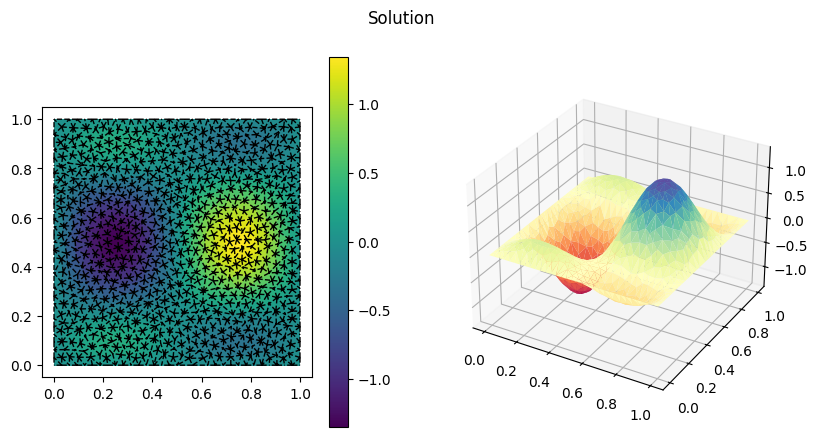

In [25]:
# Plot on the last mu of test_set
gedim.PlotSolution(mesh, dofs, strongs, last_sol, np.zeros(problemData['NumberStrongs']))
#gedim.ExportSolution(Burger_exactSolution, u_k, u_strong, lib)

[numQuadraturePoints, quadraturePoints, quadratureWeights, solution_hf, solution_x_hf, solution_y_hf] = gedim.EvaluateSolutionOnPoints(last_sol, u_strong, lib)
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, solution_hf, lib)

#### PINN

#### Defintion of the nets to be used
input dimension is 4 : (x0, x1, mu0, m1)

#### 1st Net

In [20]:
# ------------------------ Definizione della rete neurale ------------------------
class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        # Rete fully connected con 3 hidden layers e attivazione Tanh
        self.fc1 = nn.Linear(4, 64)    # input: x0, x1, mu0, mu1
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        #self.fc4 = nn.Linear(64, 64)   # layer aggiunto
        self.out = nn.Linear(64, 1)    # output: u(x, mu)
        self.activation = nn.Tanh()

    def forward(self, xmu):
        x = self.activation(self.fc1(xmu))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        #x = self.activation(self.fc4(x))  # nuovo layer
        output = self.out(x)
        return output

"""
Epoch 1: Loss = 2597.005127 (PDE = 2596.995605, BC = 0.009457)
Epoch 500: Loss = 11.469836 (PDE = 4.729046, BC = 6.740790)
Epoch 1000: Loss = 4.228578 (PDE = 1.274483, BC = 2.954095)
Epoch 1500: Loss = 2.549228 (PDE = 0.616322, BC = 1.932905)
Epoch 2000: Loss = 2.133069 (PDE = 0.460454, BC = 1.672615)
Epoch 2500: Loss = 1.862395 (PDE = 0.330738, BC = 1.531657)
Epoch 3000: Loss = 1.620392 (PDE = 0.350514, BC = 1.269878)
Epoch 3500: Loss = 1.594104 (PDE = 0.433100, BC = 1.161005)
Epoch 4000: Loss = 1.196951 (PDE = 0.217373, BC = 0.979578)
Epoch 4500: Loss = 1.060910 (PDE = 0.261154, BC = 0.799756)
Epoch 5000: Loss = 0.969210 (PDE = 0.314765, BC = 0.654444)
Epoch 5500: Loss = 0.671388 (PDE = 0.218285, BC = 0.453103)
Epoch 6000: Loss = 0.724327 (PDE = 0.361828, BC = 0.362499)
Epoch 6500: Loss = 0.447436 (PDE = 0.149465, BC = 0.297971)
Epoch 7000: Loss = 0.401649 (PDE = 0.198903, BC = 0.202746)
Epoch 7500: Loss = 0.280224 (PDE = 0.130654, BC = 0.149570)
Epoch 8000: Loss = 0.207691 (PDE = 0.095015, BC = 0.112677)
Epoch 8500: Loss = 0.185958 (PDE = 0.086639, BC = 0.099318)
Epoch 9000: Loss = 0.181710 (PDE = 0.095534, BC = 0.086177)
Epoch 9500: Loss = 0.150848 (PDE = 0.068529, BC = 0.082319)
Epoch 10000: Loss = 0.320659 (PDE = 0.247844, BC = 0.072815)"""


'\nEpoch 1: Loss = 2597.005127 (PDE = 2596.995605, BC = 0.009457)\nEpoch 500: Loss = 11.469836 (PDE = 4.729046, BC = 6.740790)\nEpoch 1000: Loss = 4.228578 (PDE = 1.274483, BC = 2.954095)\nEpoch 1500: Loss = 2.549228 (PDE = 0.616322, BC = 1.932905)\nEpoch 2000: Loss = 2.133069 (PDE = 0.460454, BC = 1.672615)\nEpoch 2500: Loss = 1.862395 (PDE = 0.330738, BC = 1.531657)\nEpoch 3000: Loss = 1.620392 (PDE = 0.350514, BC = 1.269878)\nEpoch 3500: Loss = 1.594104 (PDE = 0.433100, BC = 1.161005)\nEpoch 4000: Loss = 1.196951 (PDE = 0.217373, BC = 0.979578)\nEpoch 4500: Loss = 1.060910 (PDE = 0.261154, BC = 0.799756)\nEpoch 5000: Loss = 0.969210 (PDE = 0.314765, BC = 0.654444)\nEpoch 5500: Loss = 0.671388 (PDE = 0.218285, BC = 0.453103)\nEpoch 6000: Loss = 0.724327 (PDE = 0.361828, BC = 0.362499)\nEpoch 6500: Loss = 0.447436 (PDE = 0.149465, BC = 0.297971)\nEpoch 7000: Loss = 0.401649 (PDE = 0.198903, BC = 0.202746)\nEpoch 7500: Loss = 0.280224 (PDE = 0.130654, BC = 0.149570)\nEpoch 8000: Loss =

#### 2nd Net

In [21]:
# ------------------------ Definizione della rete neurale ------------------------
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        # Rete fully connected con 3 hidden layers e attivazione Tanh
        self.fc1 = nn.Linear(4, 64)    # input: x0, x1, mu0, mu1
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)   # layer aggiunto
        self.out = nn.Linear(64, 1)    # output: u(x, mu)
        self.activation = nn.Tanh()

    def forward(self, xmu):
        x = self.activation(self.fc1(xmu))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))  # nuovo layer
        output = self.out(x)
        return output

"""Epoch 1: Loss = 2597.340088 (PDE = 2597.321777, BC = 0.018400)
Epoch 500: Loss = 62.587612 (PDE = 58.046047, BC = 4.541564)
Epoch 1000: Loss = 4.106107 (PDE = 3.070472, BC = 1.035635)
Epoch 1500: Loss = 1.745323 (PDE = 1.115437, BC = 0.629886)
Epoch 2000: Loss = 1.032273 (PDE = 0.490336, BC = 0.541937)
Epoch 2500: Loss = 0.975894 (PDE = 0.499431, BC = 0.476464)
Epoch 3000: Loss = 0.591513 (PDE = 0.225915, BC = 0.365598)
Epoch 3500: Loss = 0.611782 (PDE = 0.301978, BC = 0.309804)
Epoch 4000: Loss = 0.404702 (PDE = 0.180035, BC = 0.224667)
Epoch 4500: Loss = 1.024114 (PDE = 0.857980, BC = 0.166134)
Epoch 5000: Loss = 0.438641 (PDE = 0.307726, BC = 0.130915)
Epoch 5500: Loss = 0.298048 (PDE = 0.196627, BC = 0.101421)
Epoch 6000: Loss = 0.226060 (PDE = 0.148805, BC = 0.077255)
Epoch 6500: Loss = 0.176941 (PDE = 0.104559, BC = 0.072382)
Epoch 7000: Loss = 0.570505 (PDE = 0.513506, BC = 0.056999)
Epoch 7500: Loss = 0.418244 (PDE = 0.368085, BC = 0.050159)
Epoch 8000: Loss = 0.176776 (PDE = 0.134688, BC = 0.042087)
Epoch 8500: Loss = 0.144343 (PDE = 0.105857, BC = 0.038486)
Epoch 9000: Loss = 0.165173 (PDE = 0.130277, BC = 0.034896)
Epoch 9500: Loss = 0.171418 (PDE = 0.136201, BC = 0.035217)
Epoch 10000: Loss = 0.112016 (PDE = 0.080488, BC = 0.031528)"""


'Epoch 1: Loss = 2597.340088 (PDE = 2597.321777, BC = 0.018400)\nEpoch 500: Loss = 62.587612 (PDE = 58.046047, BC = 4.541564)\nEpoch 1000: Loss = 4.106107 (PDE = 3.070472, BC = 1.035635)\nEpoch 1500: Loss = 1.745323 (PDE = 1.115437, BC = 0.629886)\nEpoch 2000: Loss = 1.032273 (PDE = 0.490336, BC = 0.541937)\nEpoch 2500: Loss = 0.975894 (PDE = 0.499431, BC = 0.476464)\nEpoch 3000: Loss = 0.591513 (PDE = 0.225915, BC = 0.365598)\nEpoch 3500: Loss = 0.611782 (PDE = 0.301978, BC = 0.309804)\nEpoch 4000: Loss = 0.404702 (PDE = 0.180035, BC = 0.224667)\nEpoch 4500: Loss = 1.024114 (PDE = 0.857980, BC = 0.166134)\nEpoch 5000: Loss = 0.438641 (PDE = 0.307726, BC = 0.130915)\nEpoch 5500: Loss = 0.298048 (PDE = 0.196627, BC = 0.101421)\nEpoch 6000: Loss = 0.226060 (PDE = 0.148805, BC = 0.077255)\nEpoch 6500: Loss = 0.176941 (PDE = 0.104559, BC = 0.072382)\nEpoch 7000: Loss = 0.570505 (PDE = 0.513506, BC = 0.056999)\nEpoch 7500: Loss = 0.418244 (PDE = 0.368085, BC = 0.050159)\nEpoch 8000: Loss = 

#### 3rd Net

In [22]:
# ------------------------ Definizione della rete neurale ------------------------
class Net3(nn.Module):
    def __init__(self):
        super().__init__()
        # Rete fully connected con 3 hidden layers e attivazione Tanh
        self.fc1 = nn.Linear(4, 128)    # input: x0, x1, mu0, mu1
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)   # layer aggiunto
        self.out = nn.Linear(128, 1)    # output: u(x, mu)
        self.activation = nn.Tanh()

    def forward(self, xmu):
        x = self.activation(self.fc1(xmu))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))  # nuovo layer
        output = self.out(x)
        return output

"""

Epoch 1: Loss = 2597.136963 (PDE = 2597.136719, BC = 0.000287)
Epoch 500: Loss = 6.154666 (PDE = 1.920512, BC = 4.234154)
Epoch 1000: Loss = 2.283248 (PDE = 0.541856, BC = 1.741392)
Epoch 1500: Loss = 1.700182 (PDE = 0.270185, BC = 1.429997)
Epoch 2000: Loss = 1.974079 (PDE = 0.736176, BC = 1.237903)
Epoch 2500: Loss = 4.315150 (PDE = 3.208737, BC = 1.106413)
Epoch 3000: Loss = 2.016504 (PDE = 1.133099, BC = 0.883405)
Epoch 3500: Loss = 1.832228 (PDE = 1.063244, BC = 0.768984)
Epoch 4000: Loss = 0.723247 (PDE = 0.107885, BC = 0.615362)
Epoch 4500: Loss = 0.613047 (PDE = 0.148949, BC = 0.464098)
Epoch 5000: Loss = 0.763110 (PDE = 0.423088, BC = 0.340022)
Epoch 5500: Loss = 0.338586 (PDE = 0.131679, BC = 0.206908)
Epoch 6000: Loss = 0.894268 (PDE = 0.753348, BC = 0.140920)
Epoch 6500: Loss = 2.821846 (PDE = 2.710770, BC = 0.111076)
Epoch 7000: Loss = 1.365623 (PDE = 1.294741, BC = 0.070882)
Epoch 7500: Loss = 0.434718 (PDE = 0.381838, BC = 0.052881)
Epoch 8000: Loss = 0.237456 (PDE = 0.197720, BC = 0.039736)
Epoch 8500: Loss = 0.571952 (PDE = 0.535621, BC = 0.036331)
Epoch 9000: Loss = 0.200000 (PDE = 0.165033, BC = 0.034966)
Epoch 9500: Loss = 0.116498 (PDE = 0.086488, BC = 0.030011)
Epoch 10000: Loss = 0.395694 (PDE = 0.367889, BC = 0.027805)"""

'\n\nEpoch 1: Loss = 2597.136963 (PDE = 2597.136719, BC = 0.000287)\nEpoch 500: Loss = 6.154666 (PDE = 1.920512, BC = 4.234154)\nEpoch 1000: Loss = 2.283248 (PDE = 0.541856, BC = 1.741392)\nEpoch 1500: Loss = 1.700182 (PDE = 0.270185, BC = 1.429997)\nEpoch 2000: Loss = 1.974079 (PDE = 0.736176, BC = 1.237903)\nEpoch 2500: Loss = 4.315150 (PDE = 3.208737, BC = 1.106413)\nEpoch 3000: Loss = 2.016504 (PDE = 1.133099, BC = 0.883405)\nEpoch 3500: Loss = 1.832228 (PDE = 1.063244, BC = 0.768984)\nEpoch 4000: Loss = 0.723247 (PDE = 0.107885, BC = 0.615362)\nEpoch 4500: Loss = 0.613047 (PDE = 0.148949, BC = 0.464098)\nEpoch 5000: Loss = 0.763110 (PDE = 0.423088, BC = 0.340022)\nEpoch 5500: Loss = 0.338586 (PDE = 0.131679, BC = 0.206908)\nEpoch 6000: Loss = 0.894268 (PDE = 0.753348, BC = 0.140920)\nEpoch 6500: Loss = 2.821846 (PDE = 2.710770, BC = 0.111076)\nEpoch 7000: Loss = 1.365623 (PDE = 1.294741, BC = 0.070882)\nEpoch 7500: Loss = 0.434718 (PDE = 0.381838, BC = 0.052881)\nEpoch 8000: Loss 

#### 4th Net

In [23]:
# ------------------------ Definizione della rete neurale ------------------------
class Net4(nn.Module):
    def __init__(self):
        super().__init__()
        # Rete fully connected con 3 hidden layers e attivazione Tanh
        self.fc1 = nn.Linear(4, 128)    # input: x0, x1, mu0, mu1
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 64)   # layer aggiunto
        self.out = nn.Linear(64, 1)    # output: u(x, mu)
        self.activation = nn.Tanh()

    def forward(self, xmu):
        x = self.activation(self.fc1(xmu))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))  # nuovo layer
        output = self.out(x)
        return output

"""Epoch 1: Loss = 2597.136719 (PDE = 2597.135254, BC = 0.001413)
Epoch 500: Loss = 9.076748 (PDE = 3.374595, BC = 5.702153)
Epoch 1000: Loss = 2.538052 (PDE = 0.808142, BC = 1.729909)
Epoch 1500: Loss = 1.536857 (PDE = 0.526524, BC = 1.010332)
Epoch 2000: Loss = 0.988707 (PDE = 0.202609, BC = 0.786098)
Epoch 2500: Loss = 1.747627 (PDE = 1.137176, BC = 0.610451)
Epoch 3000: Loss = 1.682362 (PDE = 1.245856, BC = 0.436506)
Epoch 3500: Loss = 0.591784 (PDE = 0.254381, BC = 0.337403)
Epoch 4000: Loss = 0.424386 (PDE = 0.187354, BC = 0.237032)
Epoch 4500: Loss = 1.247433 (PDE = 1.081949, BC = 0.165484)
Epoch 5000: Loss = 1.717268 (PDE = 1.601443, BC = 0.115825)
Epoch 5500: Loss = 0.513405 (PDE = 0.442231, BC = 0.071173)
Epoch 6000: Loss = 0.185225 (PDE = 0.127264, BC = 0.057962)
Epoch 6500: Loss = 0.143996 (PDE = 0.096147, BC = 0.047849)
Epoch 7000: Loss = 0.243929 (PDE = 0.205168, BC = 0.038762)
Epoch 7500: Loss = 0.545089 (PDE = 0.509781, BC = 0.035308)
Epoch 8000: Loss = 0.355634 (PDE = 0.326932, BC = 0.028702)
Epoch 8500: Loss = 0.106555 (PDE = 0.078650, BC = 0.027905)
Epoch 9000: Loss = 0.778025 (PDE = 0.753246, BC = 0.024779)
Epoch 9500: Loss = 0.705521 (PDE = 0.680895, BC = 0.024626)
Epoch 10000: Loss = 0.200883 (PDE = 0.178878, BC = 0.022005)"""

'Epoch 1: Loss = 2597.136719 (PDE = 2597.135254, BC = 0.001413)\nEpoch 500: Loss = 9.076748 (PDE = 3.374595, BC = 5.702153)\nEpoch 1000: Loss = 2.538052 (PDE = 0.808142, BC = 1.729909)\nEpoch 1500: Loss = 1.536857 (PDE = 0.526524, BC = 1.010332)\nEpoch 2000: Loss = 0.988707 (PDE = 0.202609, BC = 0.786098)\nEpoch 2500: Loss = 1.747627 (PDE = 1.137176, BC = 0.610451)\nEpoch 3000: Loss = 1.682362 (PDE = 1.245856, BC = 0.436506)\nEpoch 3500: Loss = 0.591784 (PDE = 0.254381, BC = 0.337403)\nEpoch 4000: Loss = 0.424386 (PDE = 0.187354, BC = 0.237032)\nEpoch 4500: Loss = 1.247433 (PDE = 1.081949, BC = 0.165484)\nEpoch 5000: Loss = 1.717268 (PDE = 1.601443, BC = 0.115825)\nEpoch 5500: Loss = 0.513405 (PDE = 0.442231, BC = 0.071173)\nEpoch 6000: Loss = 0.185225 (PDE = 0.127264, BC = 0.057962)\nEpoch 6500: Loss = 0.143996 (PDE = 0.096147, BC = 0.047849)\nEpoch 7000: Loss = 0.243929 (PDE = 0.205168, BC = 0.038762)\nEpoch 7500: Loss = 0.545089 (PDE = 0.509781, BC = 0.035308)\nEpoch 8000: Loss = 0.

#### 5th Net

In [24]:
# fa schifo (credo problema sia la sigmoide)
"""
class Net5(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input_layer = nn.Linear(4,5)
        self.hidden_layer1 = nn.Linear(5,5)
        self.hidden_layer2 = nn.Linear(5,5)
        self.hidden_layer3 = nn.Linear(5,5)
        self.hidden_layer4 = nn.Linear(5,5)
        self.output_layer = nn.Linear(5,1)

    def forward(self, x):
        input = x
        layer1_out = torch.sigmoid(self.input_layer(input))
        layer2_out = torch.sigmoid(self.hidden_layer1(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer2(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer3(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer4(layer4_out))
        output = self.output_layer(layer5_out)
        return output"""


'\nclass Net(nn.Module):\n    def __init__(self):\n        super(Net, self).__init__()\n        self.input_layer = nn.Linear(4,5)\n        self.hidden_layer1 = nn.Linear(5,5)\n        self.hidden_layer2 = nn.Linear(5,5)\n        self.hidden_layer3 = nn.Linear(5,5)\n        self.hidden_layer4 = nn.Linear(5,5)\n        self.output_layer = nn.Linear(5,1)\n\n    def forward(self, x):\n        input = x\n        layer1_out = torch.sigmoid(self.input_layer(input))\n        layer2_out = torch.sigmoid(self.hidden_layer1(layer1_out))\n        layer3_out = torch.sigmoid(self.hidden_layer2(layer2_out))\n        layer4_out = torch.sigmoid(self.hidden_layer3(layer3_out))\n        layer5_out = torch.sigmoid(self.hidden_layer4(layer4_out))\n        output = self.output_layer(layer5_out)\n        return output'

In [25]:
# ------------------------ Calcolo del residuo PDE ------------------------
def pde_residual(xmu, net):
    """
    Calcola il residuo della PDE in ogni punto (interno al dominio)
    -xmu: tensor Nx4 con (x0, x1, mu0, mu1)
    -net: la rete neurale che approssima u
    """
    xmu.requires_grad_(True)      # necessario per calcolare derivate rispetto a xmu
    u = net(xmu)                 # output della rete: u(x,mu)

    # Calcolo gradiente di u rispetto a input (x0, x1) per le derivate prime
    grads = torch.autograd.grad(u.sum(), xmu, create_graph=True)[0]
    u_x0 = grads[:, 0:1]          # ∂u/∂x0
    u_x1 = grads[:, 1:2]          # ∂u/∂x1

    # Calcolo derivate seconde per laplaciano
    u_x0x0 = torch.autograd.grad(u_x0.sum(), xmu, create_graph=True)[0][:, 0:1]  # ∂²u/∂x0²
    u_x1x1 = torch.autograd.grad(u_x1.sum(), xmu, create_graph=True)[0][:, 1:2]  # ∂²u/∂x1²
    laplacian_u = u_x0x0 + u_x1x1  # ∆u

    # Estrazione parametri mu0 e mu1
    mu0 = xmu[:, 2:3]
    mu1 = xmu[:, 3:4]

    # Coordinate spaziali
    x0 = xmu[:, 0:1]
    x1 = xmu[:, 1:2]

    # Termine sorgente g(x;mu)
    g = 100 * torch.sin(2 * np.pi * x0) * torch.cos(2 * np.pi * x1)

    # Termine non lineare con mu0, mu1
    nonlinear = (mu0 / mu1) * (torch.exp(mu1 * u) - 1)

    # Residuo PDE: -∆u + nonlinear - g = 0
    residual = -laplacian_u + nonlinear - g
    return residual

In [26]:
# ------------------------ Generazione punti dominio e bordo ------------------------
def generate_domain_points(N_interior, N_boundary, mu0_range, mu1_range):
    """
    Genera punti interni e di bordo del dominio con campionamento uniforme
    anche dei parametri mu0, mu1 negli intervalli specificati
    """
    mu0_min, mu0_max = mu0_range
    mu1_min, mu1_max = mu1_range

    # --- Punti interni ---
    x0 = torch.rand(N_interior, 1)  # coordinate x0 in (0,1)
    x1 = torch.rand(N_interior, 1)  # coordinate x1 in (0,1)
    mu0 = mu0_min + (mu0_max - mu0_min) * torch.rand(N_interior, 1)  # parametri mu0 casuali nell’intervallo
    mu1 = mu1_min + (mu1_max - mu1_min) * torch.rand(N_interior, 1)  # parametri mu1 casuali nell’intervallo
    xmu_interior = torch.cat([x0, x1, mu0, mu1], dim=1)

    # --- Punti sul bordo ---
    xb = []
    for side in range(4):
        s = torch.rand(N_boundary, 1)          # coordinata variabile sul lato
        zeros = torch.zeros_like(s)             # vettore di zeri
        ones = torch.ones_like(s)               # vettore di uni

        if side == 0:
            # lato inferiore y=0
            x0b, x1b = s, zeros
        elif side == 1:
            # lato superiore y=1
            x0b, x1b = s, ones
        elif side == 2:
            # lato sinistro x=0
            x0b, x1b = zeros, s
        else:
            # lato destro x=1
            x0b, x1b = ones, s

        mu0b = mu0_min + (mu0_max - mu0_min) * torch.rand(N_boundary, 1)  # mu0 bordo
        mu1b = mu1_min + (mu1_max - mu1_min) * torch.rand(N_boundary, 1)  # mu1 bordo

        xb.append(torch.cat([x0b, x1b, mu0b, mu1b], dim=1))

    xmu_boundary = torch.cat(xb, dim=0)
    n_boundary_points = len(xmu_boundary)



    return xmu_interior, xmu_boundary

In [27]:
# ------------------------ Funzione di training ------------------------
def train_pinn(net, epochs=20000, N_interior=1500, N_boundary=200, lr=1e-3,
               mu0_range=(0.1, 1.0), mu1_range=(0.1, 1.0), seed = 23, lambda = 1.0):
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
        """
    Addestra la rete PINN minimizzando residuo PDE e rispettando condizioni di Dirichlet
    """
    #optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    power = 2.0  # puoi cambiare questo valore
    scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: (1 - epoch / epochs) ** power)
    

    for epoch in range(1, epochs + 1):

        optimizer.zero_grad()
        net.train()
        # Genera punti (interni e bordo) con mu0, mu1 random su intervalli
        xmu_int, xmu_bnd = generate_domain_points(N_interior, N_boundary, mu0_range, mu1_range)
        #print(xmu_int[0])
        # Calcola residuo PDE sui punti interni
        res_int = pde_residual(xmu_int, net)
        loss_pde = torch.mean(res_int ** 2)

        # Valuta la rete sui punti di bordo (condizione Dirichlet u=0)
        u_bnd = net(xmu_bnd)
        # qua residuo è u_bnd - 0
        loss_bc = torch.mean(u_bnd ** 2)

        # Loss totale: somma tra PDE residual e condizione al contorno (dovrei aggiungere un lambda)
        loss =  loss_pde +  lambda * loss_bc

        loss.backward()
        optimizer.step()
        scheduler.step()


    if epoch % 500 == 0 or epoch == 1:
        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch}: Loss = {loss.item():.6f} (PDE = {loss_pde.item():.6f}, BC = {loss_bc.item():.6f}), LR = {current_lr:.2e}")


In [28]:
net = Net()
train_pinn(net,
           epochs=10000,
           N_interior=1500,
           N_boundary=200,
           lr=1e-3,
           mu0_range=(0.1, 1.0),
           mu1_range=(0.1, 1.0))

KeyboardInterrupt: 

In [ ]:
# Fissa parametri mu0 e mu1
mu0_val = 0.5
mu1_val = 0.5

# Griglia su (x0, x1)
x0 = np.arange(0, 1.01, 0.02)
x1 = np.arange(0, 1.01, 0.02)
X0, X1 = np.meshgrid(x0, x1)

# Prepara input per la rete: (x0, x1, mu0, mu1)
x0_flat = X0.flatten()[:, None]
x1_flat = X1.flatten()[:, None]
mu0_flat = mu0_val * np.ones_like(x0_flat)
mu1_flat = mu1_val * np.ones_like(x0_flat)

inputs = np.hstack([x0_flat, x1_flat, mu0_flat, mu1_flat])
inputs_torch = torch.from_numpy(inputs).float()

# Predizione rete (assumendo 'net' già addestrata e in eval mode)
net.eval()
with torch.no_grad():
    u_pred = net(inputs_torch).cpu().numpy()

# Ricostruisci la matrice della soluzione
U = u_pred.reshape(X0.shape)

# Plot 3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X0, X1, U, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
ax.set_zlabel('$u(x_0,x_1)$')
ax.set_title(f'Soluzione PINN con $\\mu_0={mu0_val}$, $\\mu_1={mu1_val}$')

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import os

# Cerca tutti i file CSV che contengono il valore di lambda nel nome
csv_files = glob.glob("./training_log_lambda*.csv")

# Ordina i file per lambda (estratto dal nome)
def extract_lambda(filename):
    m = re.search(r"lambda([0-9.]+)", filename)
    return float(m.group(1)) if m else 0

csv_files = sorted(csv_files, key=extract_lambda)

n_files = len(csv_files)
n_cols = 2
n_rows = (n_files + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5*n_rows), squeeze=False)

column_names = ["net", "epoch", "loss", "pde_loss", "bc_loss", "epoch_time_s", "elapsed_s", "lambda_weight"]

for i, csv_path in enumerate(csv_files):
    ax = axes[i//n_cols, i%n_cols]
    lam = extract_lambda(csv_path)
    df = pd.read_csv(csv_path, header=0, names=column_names)

    nets = df['net'].unique()

    for net in nets:
        df_net = df[df['net'] == net].sort_values('epoch')
        loss_smooth = df_net['loss'].rolling(window=10, min_periods=1).mean()
        ax.plot(df_net['epoch'], loss_smooth, label=net)

    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel("Loss", fontsize=12)
    ax.set_title(f"Training Loss (λ={lam:.3f})", fontsize=14)
    ax.grid(True)
    ax.legend(fontsize=10)

# Rimuove subplot vuoti se ci sono
for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axes[j//n_cols, j%n_cols])

plt.tight_layout()
plt.show()


ValueError: could not convert string to float: '1.000.'

In [33]:
# cella 1 – installazione (solo la prima volta)
!pip install pandas matplotlib
!python3 -m pip install --upgrade pip


  Using cached pandas-2.2.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 59.9 kB/s eta 0:00:0000:0400:09
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pandas]2m2/3 [pandas]


Net1: final loss 0.015963 at epoch 20000
Net2: final loss 0.016504 at epoch 20000
Net3: final loss 0.006674 at epoch 20000
Net4: final loss 0.007015 at epoch 20000
Net6: final loss 0.068705 at epoch 20000
Net7: final loss 0.139764 at epoch 20000
Net8: final loss 0.021701 at epoch 20000
Net9: final loss 0.076327 at epoch 20000
Net10: final loss 0.041135 at epoch 20000
Net11: final loss 0.024637 at epoch 20000
Net12: final loss 0.377463 at epoch 20000


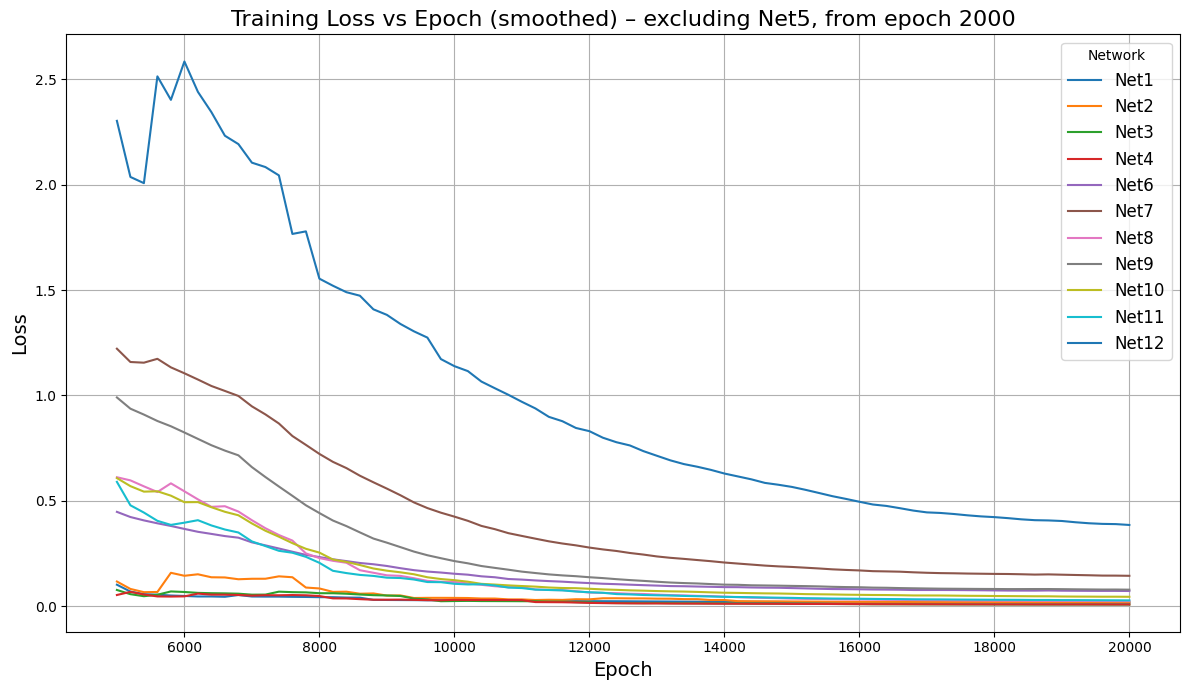

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "./training_log_lambda1.000.csv"

# ---------- 1. lettura -------------------------------------------------
df = pd.read_csv(csv_path)          # header=0 riconosciuto

# ---------- 2. pulizia lambda_weight ----------------------------------
lambda_col = "lambda_weight;;;;;;;;"
df[lambda_col] = (
    df[lambda_col]
    .astype(str)            # sicuro che sia stringa
    .str.replace(";", "", regex=False)   # rimuovi tutti i ;
    .astype(float)
)

# ---------- 3. cast numerico delle colonne chiave ---------------------
num_cols = ["epoch", "loss", "pde_loss", "bc_loss"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")
df = df.dropna(subset=num_cols)     # scarta righe con NaN (se ce ne sono)
df["epoch"] = df["epoch"].astype(int)

# ---------- 4. plot ----------------------------------------------------
nets = [n for n in df["net"].unique() if n.lower() != "net5"]

plt.figure(figsize=(12, 7))

for net in nets:
    dfn = df[(df["net"] == net) & (df["epoch"] >= 5000)].sort_values("epoch")
    if dfn.empty:
        continue

    loss_smooth = dfn["loss"].rolling(window=10, min_periods=1).mean()
    plt.plot(dfn["epoch"], loss_smooth, label=net)

    final_loss = dfn["loss"].iloc[-1]
    print(f"{net}: final loss {final_loss:.6f} at epoch {dfn['epoch'].iloc[-1]}")

plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Training Loss vs Epoch (smoothed) – excluding Net5, from epoch 2000", fontsize=16)
plt.legend(title="Network", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [40]:
import pandas as pd
import csv, itertools

csv_path = "./training_log_lambda1.000.csv"

# --- 1. stampa le prime due righe grezze -----------------------------
with open(csv_path, newline="") as f:
    reader = csv.reader(f)
    first_two = list(itertools.islice(reader, 2))
print("Prime due righe grezze:")
for r in first_two:
    print(r)

# --- 2a. leggi lasciando che pandas rilevi l'header ------------------
df_auto = pd.read_csv(csv_path)          # header=0 di default
print("\n>>> Caricamento AUTOMATICO")
print(df_auto.dtypes)
print(df_auto.head(2))

# --- 2b. leggi forzando header=None ----------------------------------
base_cols = ["col"+str(i) for i in range(len(df_auto.columns))]
df_none = pd.read_csv(csv_path, header=None, names=base_cols)
print("\n>>> Caricamento header=None")
print(df_none.dtypes)
print(df_none.head(2))

# --- 3. suggerimento -------------------------------------------------
has_non_numeric_epoch = pd.to_numeric(df_auto.iloc[0,1], errors="coerce").isna()
if has_non_numeric_epoch:
    print("\n⚠️  Sembra che la prima riga NON sia dati ma intestazione.")
    print("   → Usa  header=0  (o semplicemente ometti header=None).")
else:
    print("\n✅  La prima riga pare già dati numerici.")
    print("   → Usa  header=None  e passa una lista di nomi colonne.")


Prime due righe grezze:
['net', 'epoch', 'loss', 'pde_loss', 'bc_loss', 'epoch_time_s', 'elapsed_s', 'lambda_weight;;;;;;;;']
['Net1', '1', '0.035779', '0.010013', '0.025765', '0.009', '0.009', '1.000;;;;;;;;']

>>> Caricamento AUTOMATICO
net                       object
epoch                      int64
loss                     float64
pde_loss                 float64
bc_loss                  float64
epoch_time_s             float64
elapsed_s                float64
lambda_weight;;;;;;;;     object
dtype: object
    net  epoch      loss  pde_loss   bc_loss  epoch_time_s  elapsed_s  \
0  Net1      1  0.035779  0.010013  0.025765         0.009      0.009   
1  Net1    200  0.041600  0.012635  0.028965         0.013      2.140   

  lambda_weight;;;;;;;;  
0         1.000;;;;;;;;  
1         1.000;;;;;;;;  

>>> Caricamento header=None
col0    object
col1    object
col2    object
col3    object
col4    object
col5    object
col6    object
col7    object
dtype: object
   col0   col1      co

AttributeError: 'numpy.int64' object has no attribute 'isna'

In [49]:
import pandas as pd

df = pd.read_csv(csv_path)
print(df.columns)


Index(['Net1', '1', '2602.945557', '2602.936035', '0.009406', '0.013',
       '0.013.1'],
      dtype='object')


In [ ]:
"""import torch.nn as nn

# ------------------------------------------------------------------
# Net6 – quattro hidden layer da 128→128→128→64
# ------------------------------------------------------------------
class Net6(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)   # layer extra
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 64)     # layer già presente in Net4
        self.out = nn.Linear(64, 1)
        self.act = nn.Tanh()

    def forward(self, xmu):
        x = self.act(self.fc1(xmu))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))   # nuovo passaggio
        x = self.act(self.fc4(x))
        x = self.act(self.fc5(x))
        return self.out(x)


# ------------------------------------------------------------------
# Net7 – cinque hidden layer a piramide 256→192→128→96→64
# ------------------------------------------------------------------
class Net7(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 256)
        self.fc2 = nn.Linear(256, 192)
        self.fc3 = nn.Linear(192, 128)
        self.fc4 = nn.Linear(128, 96)    # layer extra
        self.fc5 = nn.Linear(96, 64)
        self.out = nn.Linear(64, 1)
        self.act = nn.Tanh()

    def forward(self, xmu):
        x = self.act(self.fc1(xmu))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = self.act(self.fc4(x))   # nuovo layer
        x = self.act(self.fc5(x))
        return self.out(x)


# ------------------------------------------------------------------
# Net8 – sei hidden layer uniformi 128↦128, con residual skip
# ------------------------------------------------------------------
class Net8(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(4 if i == 0 else 128, 128) 
                                     for i in range(6)])  # 6 hidden layer
        self.out = nn.Linear(128, 1)
        self.act = nn.Tanh()

    def forward(self, xmu):
        x = xmu
        for i, layer in enumerate(self.layers):
            h = self.act(layer(x))
            # skip residual ogni due layer
            if i % 2 == 1:
                x = (x + h) / 2  
            else:
                x = h
        return self.out(x)
"""

#### Finora ho fatta lambda = 1
##### Provo:
1. lambda = 0.5
2. lambda = 0.75
3. lambda = 1.25
4. lambda = 1.5
Poi, in base ai risulati, vedo quale performa meglio e rifaccio tutto con le nuove 3 reti + la 4

come capire che lambda tenere? plotta per la miglior rete coma variano le loss e capisci se c'è bisogno di imprre lambda != 1

λ=1.000 | Net1: epoch 20000, PDE 2.9311e-02, BC 4.9604e-02
λ=2.000 | Net2: epoch 20000, PDE 1.9371e-02, BC 2.2723e-02
λ=3.000 | Net3: epoch 20000, PDE 1.3307e-02, BC 2.3610e-02
λ=4.000 | Net4: epoch 20000, PDE 9.8210e-03, BC 1.8338e-02


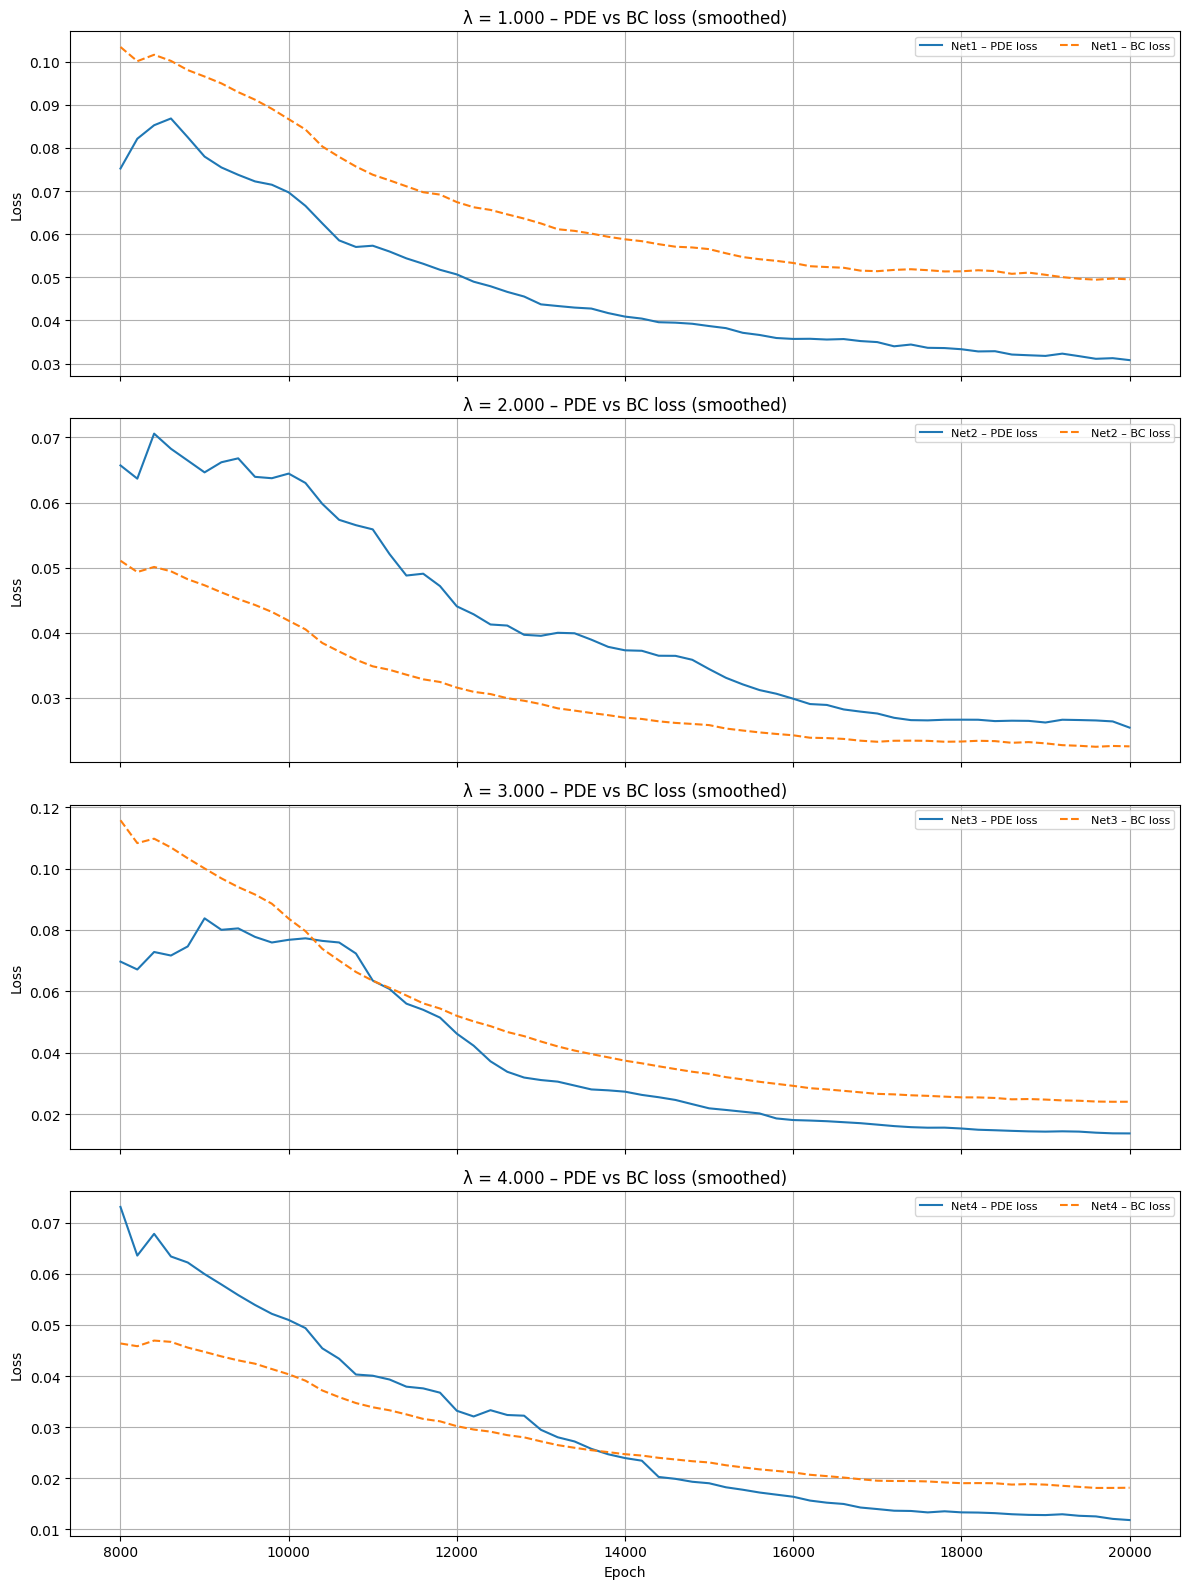

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import glob, re, os

# 1. Carica tutti i CSV
csv_files = glob.glob("./training_log*.csv")
if not csv_files:
    raise FileNotFoundError("Nessun file training_log*.csv trovato.")

base_cols = ["net", "epoch", "loss", "pde_loss", "bc_loss",
             "epoch_time_s", "elapsed_s"]

df_list = []
for path in csv_files:
    has_header = not pd.read_csv(path, nrows=0).empty
    tmp = pd.read_csv(path) if has_header else pd.read_csv(path, header=None, names=base_cols)
    tmp['source_csv'] = os.path.basename(path)
    df_list.append(tmp)

df = pd.concat(df_list, ignore_index=True)

# 2. Preprocessing
df['epoch'] = pd.to_numeric(df['epoch'], errors='coerce')
df = df.dropna(subset=['epoch'])
df['epoch'] = df['epoch'].astype(int)

for col in ['pde_loss', 'bc_loss']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# filtra epoche >= 8000 e rimuove net5
df = df[df['epoch'] >= 8000]
df = df[~df['net'].str.lower().str.contains('net5')]

# 3. Estrai lambda
lam_pat = re.compile(r"λ?[_\-]?(\d*\.?\d+)")
def extract_lambda(row):
    for text in (row['net'], row['source_csv']):
        m = lam_pat.search(text)
        if m:
            return float(m.group(1))
    return float('nan')

df['lambda'] = df.apply(extract_lambda, axis=1)
df = df.dropna(subset=['lambda'])

# 4. Plot: per ogni lambda, subplot verticale con tutte le reti in quel lambda

lambdas = sorted(df['lambda'].unique())
fig, axes = plt.subplots(len(lambdas), 1, figsize=(12, 4*len(lambdas)), sharex=True)
if len(lambdas) == 1:
    axes = [axes]

for ax, lam in zip(axes, lambdas):
    dfl = df[df['lambda'] == lam].sort_values('epoch')
    nets = sorted(dfl['net'].unique())

    for net in nets:
        dfn = dfl[dfl['net'] == net]
        pde = dfn['pde_loss'].rolling(window=10, min_periods=1).mean()
        bc = dfn['bc_loss'].rolling(window=10, min_periods=1).mean()

        ax.plot(dfn['epoch'], pde, label=f'{net} – PDE loss')
        ax.plot(dfn['epoch'], bc, ls='--', label=f'{net} – BC loss')

        # stampa valori finali
        print(f"λ={lam:.3f} | {net}: epoch {dfn['epoch'].iloc[-1]}, PDE {dfn['pde_loss'].iloc[-1]:.4e}, BC {dfn['bc_loss'].iloc[-1]:.4e}")

    ax.set_title(f"λ = {lam:.3f} – PDE vs BC loss (smoothed)")
    ax.set_ylabel("Loss")
    ax.grid(True)
    ax.legend(fontsize=8, ncol=2)

axes[-1].set_xlabel("Epoch")
plt.tight_layout()
plt.show()
